# Fine-tune Meta Llama2 13B model provided by Amazon Bedrock: End-to-End

In this notebook we demonstrate using Boto3 sdk for the fine-tuning and provisioning of [Llama2 13B](#https://ai.meta.com/llama/get-started/) model in Bedrock. You can also do this through the Bedrock Console.

<div class="alert alert-block alert-warning">
<b>Warning:</b> This module cannot be executed in Workshop Studio Accounts, and you will have to run this notebook in your own account.
</div>

### A Summarization Use Case
In this notebook, we build an end-to-end workflow for fine-tuning and evaluating the Foundation Models (FMs) in Amazon Bedrock. We choose [Meta Llama 2 13B](https://ai.meta.com/llama/) as our FM to perform the customization through fine-tuning, we then create provisioned throughput of the fine-tuned model, test the provisioned model invocation, and finally evaluate the fine-tuned model performance using [fmeval](https://github.com/aws/fmeval) on the summarization accuracy metrics including METEOR, ROUGE, and BERT scores. We have defined these scores in the `Evaluate the Provisioned Custom Model¶` section below. 

> *This notebook should work well with the **`Data Science 3.0`**, **`Python 3`**, and **`ml.c5.2xlarge`** kernel in SageMaker Studio*

## Prerequisites

 - Make sure you have executed `00_setup.ipynb` notebook.
 - Make sure you are using the same kernel and instance as `00_setup.ipynb` notebook.

In this notebook we demonstrate using Boto3 sdk for the fine-tuning and provisioning of [Llama2 13B](#https://ai.meta.com/llama/get-started/) model in Bedrock. You can also do this through the Bedrock Console.

<div class="alert alert-block alert-warning">
<b>Warning:</b> This notebook will create provisioned throughput for testing the fine-tuned model. Therefore, please make sure to delete the provisioned throughput as mentioned in the last section of the notebook, otherwise you will be charged for it, even if you are not using it.
</div>

## Setup
Install and import all the needed libraries and dependencies to complete this notebook.

Please ignore error messages related to pip's dependency resolver.

In [2]:
# # install the fmeval package for foundation model evaluation
!rm -Rf ~/.cache/pip/*
!pip install tokenizers==0.12.1
!pip install -qU fmeval==0.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 39.9 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.42.4 requires tokenizers<0.20,>=0.19, but you have tokenizers 0.12.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 7.2.6 requires docutils<0.21,>=0.18.1, but you have docutils 0.16 which is incompatible.


#### Setup Tips:
⚠️ ⚠️ ⚠️ If you have trouble installing fmeval, please make sure you have the dependencies installed correctly. See full list of dependencies [here](https://github.com/aws/fmeval/blob/main/poetry.lock). ⚠️ ⚠️ ⚠️ 


In [3]:
# restart kernel for packages to take effect
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [4]:
## Fetching varialbes from `00_setup.ipynb` notebook. 
%store -r role_arn
%store -r s3_train_uri
%store -r s3_validation_uri
%store -r s3_test_uri
%store -r bucket_name

In [5]:
import pprint
pprint.pp(role_arn)
pprint.pp(s3_train_uri)
pprint.pp(s3_validation_uri)
pprint.pp(s3_test_uri)
pprint.pp(bucket_name)

'arn:aws:iam::094784590684:role/BedrockRole-257549b9-3aff-4c30-86e9-530c1416e6ac'
's3://bedrock-customization-us-east-1-094784590684/fine-tuning-datasets/train/train-cnn-5K.jsonl'
's3://bedrock-customization-us-east-1-094784590684/fine-tuning-datasets/validation/validation-cnn-1K.jsonl'
's3://bedrock-customization-us-east-1-094784590684/fine-tuning-datasets/test/test-cnn-10.jsonl'
'bedrock-customization-us-east-1-094784590684'


In [6]:
import warnings
warnings.filterwarnings('ignore')
import json
import os
import sys
import boto3
import pandas as pd
from matplotlib import pyplot as plt

In [7]:
session = boto3.session.Session()
region = session.region_name
sts_client = boto3.client('sts')
s3_client = boto3.client('s3')
aws_account_id = sts_client.get_caller_identity()["Account"]
bedrock = boto3.client(service_name="bedrock")
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

In [8]:
test_file_name = "test-cnn-10.jsonl"
data_folder = "fine-tuning-datasets"

## Create the Fine-Tuning Job
<div class="alert alert-block alert-info">
<b>Note:</b> Fine-tuning job will take around 60mins to complete with 5K records.</div>

Meta Llama2 customization hyperparameters: 
- `epochs`: The number of iterations through the entire training dataset and can take up any integer values in the range of 1-10, with a default value of 2.
- `batchSize`: The number of samples processed before updating model parametersand can take up any integer values in the range of 1-64, with a default value of 1.
- `learningRate`:	The rate at which model parameters are updated after each batch	which can take up a float value betweek 0.0-1.0 with a default value set to	1.00E-5.
- `learningRateWarmupSteps`: The number of iterations over which the learning rate is gradually increased to the specified rate and can take any integer value between 0-250 with a default value of 5.

For guidelines on setting hyper-parameters refer to the guidelines provided [here](#https://docs.aws.amazon.com/bedrock/latest/userguide/model-customization-guidelines.html)

In [9]:
from datetime import datetime
ts = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Choose the foundation model you want to customize and provide ModelId(find more about model reference at https://docs.aws.amazon.com/bedrock/latest/userguide/bedrock-reference.html)
base_model_id = "meta.llama2-13b-v1:0:4k"

# Select the customization type from "FINE_TUNING" or "CONTINUED_PRE_TRAINING". 
customization_type = "FINE_TUNING"

# Specify the roleArn for your customization job
customization_role = role_arn

# Create a customization job name
customization_job_name = f"llama2-finetune-sm-test-model-{ts}"

# Create a customized model name for your fine-tuned Llama2 model
custom_model_name = f"llama2-finetune-{ts}"

# Define the hyperparameters for fine-tuning Llama2 model
hyper_parameters = {
        "epochCount": "2",
        "batchSize": "1",
        "learningRate": "0.00005",
    }

# Specify your data path for training, validation(optional) and output
training_data_config = {"s3Uri": s3_train_uri}

# # uncomment the below section if you have validation dataset and provide the s3 uri for it. 
validation_data_config = {
        "validators": [{
            "s3Uri": s3_validation_uri
        }]
    }

output_data_config = {"s3Uri": f's3://{bucket_name}/outputs/output-{custom_model_name}'}

# # Create the customization job
bedrock.create_model_customization_job(
    customizationType=customization_type,
    jobName=customization_job_name,
    customModelName=custom_model_name,
    roleArn=customization_role,
    baseModelIdentifier=base_model_id,
    hyperParameters=hyper_parameters,
    trainingDataConfig=training_data_config,
    validationDataConfig=validation_data_config,
    outputDataConfig=output_data_config
)

{'ResponseMetadata': {'RequestId': '814513c4-65b0-41bc-b83e-5abae996cf6c',
  'HTTPStatusCode': 201,
  'HTTPHeaders': {'date': 'Fri, 12 Jul 2024 05:39:59 GMT',
   'content-type': 'application/json',
   'content-length': '112',
   'connection': 'keep-alive',
   'x-amzn-requestid': '814513c4-65b0-41bc-b83e-5abae996cf6c'},
  'RetryAttempts': 0},
 'jobArn': 'arn:aws:bedrock:us-east-1:094784590684:model-customization-job/meta.llama2-13b-v1:0:4k/hj6q5t4jcg91'}

## Check Customization Job Status

In [10]:
import time
fine_tune_job = bedrock.get_model_customization_job(jobIdentifier=customization_job_name)["status"]
print(fine_tune_job)

while fine_tune_job == "InProgress":
    time.sleep(60)
    fine_tune_job = bedrock.get_model_customization_job(jobIdentifier=customization_job_name)["status"]
    print (fine_tune_job)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


## Retrieve Custom Model
Once the customization job is finished, you can check your existing custom model(s) and retrieve the modelArn of your fine-tuned Llama2 model.

In [11]:
# You can list your custom models using the command below
bedrock.list_custom_models()

{'ResponseMetadata': {'RequestId': 'c13432a9-498c-4300-8b6b-5297b2664c86',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 12 Jul 2024 06:26:07 GMT',
   'content-type': 'application/json',
   'content-length': '3719',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'c13432a9-498c-4300-8b6b-5297b2664c86'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1:094784590684:custom-model/meta.llama2-13b-v1:0:4k/vrme87cn827l',
   'modelName': 'llama2-finetune-2024-07-12-05-39-59',
   'creationTime': datetime.datetime(2024, 7, 12, 5, 39, 59, 672000, tzinfo=tzlocal()),
   'baseModelArn': 'arn:aws:bedrock:us-east-1::foundation-model/meta.llama2-13b-v1:0:4k',
   'baseModelName': '',
   'customizationType': 'FINE_TUNING'},
  {'modelArn': 'arn:aws:bedrock:us-east-1:094784590684:custom-model/cohere.command-light-text-v14:7:4k/jglb0h06zthe',
   'modelName': 'cnn-daily-ft-20240630',
   'creationTime': datetime.datetime(2024, 6, 30, 2, 24, 3, 210000, tzinfo

<div class="alert alert-block alert-info">
<b>Note:</b> Please make sure your customization job status is "completed" before proceeding to retrieve the modelArn, otherwise you will run into errors. </div>


In [12]:
# retrieve the modelArn of the fine-tuned model
fine_tune_job = bedrock.get_custom_model(modelIdentifier=custom_model_name)
custom_model_id = fine_tune_job['modelArn']

In [13]:
output_job_name = "model-customization-job-"+fine_tune_job['jobArn'].split('/')[-1]
output_job_name

'model-customization-job-hj6q5t4jcg91'

## Visualize Training and Validation Loss
Now that we have completed fine-tuning job, lets visualize our results to see if our job is not underfitting or overfitting. 

Download model customization job metrics from S3 and plot the learning curves.

In [14]:
output_metrics_path = f"fine-tuning-datasets/{output_job_name}"

In [15]:
!mkdir $output_metrics_path

In [16]:
train_metrics_s3_prefix=f'outputs/output-{custom_model_name}/{output_job_name}/training_artifacts/step_wise_training_metrics.csv'
validation_metrics_s3_prefix=f'outputs/output-{custom_model_name}/{output_job_name}/validation_artifacts/post_fine_tuning_validation/validation/validation_metrics.csv'
train_metrics_name='train_metrics.csv'
validation_metrics_name='validation_metrics.csv'
train_file_name_local=output_metrics_path+'/'+train_metrics_name
validation_file_name_local=output_metrics_path+'/'+validation_metrics_name

In [17]:
s3_client.download_file(bucket_name, train_metrics_s3_prefix, train_file_name_local)
s3_client.download_file(bucket_name, validation_metrics_s3_prefix, validation_file_name_local)

In [18]:
train_data = pd.read_csv(train_file_name_local)
'''The training loss is at an iteration level. To calculate loss at the epoch level,
    average the iteration-level loss for each epoch'''
train_metrics_epoch=train_data.groupby('epoch_number').mean()
validation_metrics_epoch=pd.read_csv(validation_file_name_local)


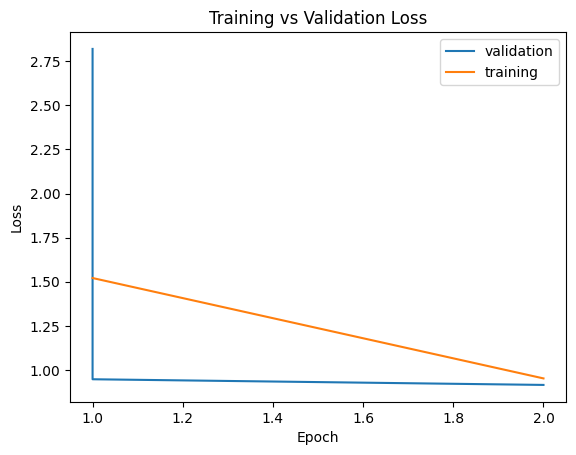

In [19]:
plt.plot(validation_metrics_epoch.epoch_number, validation_metrics_epoch.validation_loss,label='validation')
plt.plot(train_metrics_epoch.index, train_metrics_epoch.training_loss,label='training')
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Create Provisioned Throughput
<div class="alert alert-block alert-info">
<b>Note:</b> Creating provisioned throughput will take around 20-30mins to complete.</div>
You will need to create provisioned throughput to be able to evaluate the model performance. You can do so through the [console](https://docs.aws.amazon.com/bedrock/latest/userguide/prov-cap-console.html) or use the following api call.

In [20]:
# Create the provision throughput job and retrieve the provisioned model id
provisioned_model_id = bedrock.create_provisioned_model_throughput(
     modelUnits=1,
    # create a name for your provisioned throughput model
     provisionedModelName='test-model-v1-001', 
     modelId=custom_model_id
    )['provisionedModelArn']    

In [21]:
# check provisioned throughput job status
import time
status_provisioning = bedrock.get_provisioned_model_throughput(provisionedModelId = provisioned_model_id)['status'] 
while status_provisioning == 'Creating':
    time.sleep(60)
    status_provisioning = bedrock.get_provisioned_model_throughput(provisionedModelId=provisioned_model_id)['status']
    print(status_provisioning)

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService


## Invoke the Provisioned Custom Model
Invoke the privisioned custom model.You can replace the follwing prompt_txt with the prompts that are more similar to your fine-tuning dataset, this helps to check whether the fine-tuned model is performing as you expected. 

<div class="alert alert-block alert-info">
<b>Note:</b> Please make sure your provisioned throughput job status becomes InService before proceeding. </div>

In [22]:
# Provide the prompt text 
test_file_path = f'{data_folder}/{test_file_name}'
with open(test_file_path) as f:
    lines = f.read().splitlines()

In [23]:
test_prompt = json.loads(lines[0])['prompt']
reference_summary = json.loads(lines[0])['completion']
print(test_prompt)
print()
print(reference_summary)

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

instruction:

Summarize the news article provided below.

input:

Pep Guardiola was left purring at Bayern Munich's first-half performance against Porto as the club put a turbulent week behind them to storm in to the Champions League semi-finals. A 3-1 first leg defeat in Portugal last week followed by the dramatic resignation of long-serving club doctor Hans-Wilhelm Muller-Wohlfahrt had turned the spotlight on Guardiola heading in to the tie. But the Bayern boss reminded the watching world why he is considered by many to be the best manager in the business as his side raced in to a 5-0 lead before half-time on Tuesday night. Bayern Munich players celebrate in front of their fans after the 6-1 demolition of Porto on Tuesday night . Pep Guardiola looks animated as he issues instructions from the touchline at the Allianz Arena . 'I

Construct model input following the format needed by Llama2 model following instructions [here](#https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-meta.html).
Please pay attention to the "Model invocation request body field" section

In [24]:
body = json.dumps({
    "prompt": test_prompt,
    # specify the parameters as needed
    "max_gen_len": 200,
    "temperature": 0.4,
    "top_p": 0.3,
})

# provide the modelId of the provisioned custom model
modelId = provisioned_model_id
accept = 'application/json'
contentType = 'application/json'

# invoke the provisioned custom model
response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)

response_body = json.loads(response.get('body').read())
print(response_body)

{'generation': " response:\n\nBayern Munich put a turbulent week behind them to storm in to the Champions League semi-finals .\nPep Guardiola's side raced in to a 5-0 lead before half-time on Tuesday night .\nGuardiola reminded the watching world why he is considered by many to be the best manager in the business .", 'prompt_token_count': 531, 'generation_token_count': 85, 'stop_reason': 'stop'}


## Clean up
<div class="alert alert-block alert-warning">
<b>Warning:</b> Please make sure to delete providsioned throughput with the following code as there will be cost incurred if its left in running state, even if you are not using it. 
</div>

In [25]:
# delete the provisioned throughput
bedrock.delete_provisioned_model_throughput(provisionedModelId=provisioned_model_id)

{'ResponseMetadata': {'RequestId': '2d0ec641-3779-4b8b-8812-bdb231931047',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Fri, 12 Jul 2024 06:38:00 GMT',
   'content-type': 'application/json',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '2d0ec641-3779-4b8b-8812-bdb231931047'},
  'RetryAttempts': 0}}

<div class="alert alert-block alert-info">
<b>Note:</b> Please finish up the cleaning process by running 04_cleanup.ipynb to clean up the other resources. </div>